# Proyecto 1
Universidad del Valle de Guatemala, 29 de agosto de 2025<br>
Resposible IA, Sección 10

**Author(s):**
- Andrea Ximena Ramirez Recinos (21874)
- Adrian Ricardo Flores Trujillo (21500)
- Daniel Armando Valdez Reyes (21240)

***

In [ ]:
!pip install ucimlrepo

### Importación de liberías ⬇️

In [ ]:
# Standard library
import base64
import datetime as dt
import io
import os
from typing import Any, Dict, List, Optional, Tuple

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Análisis exploratorio del dataset

### Carga inicial del dataset
Primero se carga el dataset **Adult** desde UCI con `fetch_ucirepo(id=2)` y luego separamos las **features** en `X` y la **variable objetivo** en `y`. Al desplegar `adult.variables` se puede confirmar la estructura básica: una mezcla de variables **enteras** (como `age`, `capital-gain`, `capital-loss`, `hours-per-week`) y **categóricas/binarias** (por ejemplo `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`). La columna **objetivo** es `income` (binaria: `>50K` vs `<=50K`). También se ve desde el inicio que hay **valores faltantes** en algunas columnas categóricas (`workclass`, `occupation`, `native-country`), así que más adelante se va a tener que decidir cómo tratarlos.


In [ ]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# variable information
display(adult.variables)

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [ ]:
display(X.head(5))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


## Evaluamos las categorías de las variables categóricas.

In [ ]:
classCat = ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'native-country']

for c in classCat:
    uniques = pd.Series(X[c].unique(), name='category')
    tbl = (
        uniques.to_frame()
        .sort_values('category', key=lambda s: s.astype(str))
        .reset_index(drop=True)
    )
    tbl.insert(0, '#', range(1, len(tbl) + 1))
    print(f"\n===== {c} =====")
    display(tbl)



===== workclass =====


,#,category
0,1,?
1,2,Federal-gov
2,3,Local-gov
3,4,Never-worked
4,5,Private
5,6,Self-emp-inc
6,7,Self-emp-not-inc
7,8,State-gov
8,9,Without-pay
9,10,NaN



===== education =====


,#,category
0,1,10th
1,2,11th
2,3,12th
3,4,1st-4th
4,5,5th-6th
5,6,7th-8th
6,7,9th
7,8,Assoc-acdm
8,9,Assoc-voc
9,10,Bachelors



===== marital-status =====


,#,category
0,1,Divorced
1,2,Married-AF-spouse
2,3,Married-civ-spouse
3,4,Married-spouse-absent
4,5,Never-married
5,6,Separated
6,7,Widowed



===== occupation =====


,#,category
0,1,?
1,2,Adm-clerical
2,3,Armed-Forces
3,4,Craft-repair
4,5,Exec-managerial
5,6,Farming-fishing
6,7,Handlers-cleaners
7,8,Machine-op-inspct
8,9,Other-service
9,10,Priv-house-serv



===== relationship =====


,#,category
0,1,Husband
1,2,Not-in-family
2,3,Other-relative
3,4,Own-child
4,5,Unmarried
5,6,Wife



===== race =====


,#,category
0,1,Amer-Indian-Eskimo
1,2,Asian-Pac-Islander
2,3,Black
3,4,Other
4,5,White



===== sex =====


,#,category
0,1,Female
1,2,Male



===== native-country =====


,#,category
0,1,?
1,2,Cambodia
2,3,Canada
3,4,China
4,5,Columbia
5,6,Cuba
6,7,Dominican-Republic
7,8,Ecuador
8,9,El-Salvador
9,10,England


> Se detectaron categorías con la forma `?`, son iguales que decir que no se conoce el dato. Son una fuente de sesgo. Por ende con fines de limpieza se colocaron como valores NAN.

In [ ]:
# La categoria ? en workclass debe ser convertida en nan
X['workclass'] = X['workclass'].replace('?', pd.NA)

# Display the rows where 'workclass' was '?' to verify the change
display(X[X['workclass'].isna()])

# La categoria ? en workclass debe ser convertida en nan
X['occupation'] = X['occupation'].replace('?', pd.NA)

# Display the rows where 'workclass' was '?' to verify the change
display(X[X['occupation'].isna()])

# La categoria ? en workclass debe ser convertida en nan
X['native-country'] = X['native-country'].replace('?', pd.NA)

# Display the rows where 'workclass' was '?' to verify the change
display(X[X['native-country'].isna()])

/tmp/ipython-input-163273936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['workclass'] = X['workclass'].replace('?', pd.NA)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
27,54,<NA>,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South
61,32,<NA>,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?
69,25,<NA>,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States
77,67,<NA>,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States
106,17,<NA>,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


/tmp/ipython-input-163273936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['occupation'] = X['occupation'].replace('?', pd.NA)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
27,54,<NA>,180211,Some-college,10,Married-civ-spouse,<NA>,Husband,Asian-Pac-Islander,Male,0,0,60,South
61,32,<NA>,293936,7th-8th,4,Married-spouse-absent,<NA>,Not-in-family,White,Male,0,0,40,?
69,25,<NA>,200681,Some-college,10,Never-married,<NA>,Own-child,White,Male,0,0,40,United-States
77,67,<NA>,212759,10th,6,Married-civ-spouse,<NA>,Husband,White,Male,0,0,2,United-States
106,17,<NA>,304873,10th,6,Never-married,<NA>,Own-child,White,Female,34095,0,32,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


/tmp/ipython-input-163273936.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['native-country'] = X['native-country'].replace('?', pd.NA)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,<NA>
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,<NA>
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,<NA>
61,32,<NA>,293936,7th-8th,4,Married-spouse-absent,<NA>,Not-in-family,White,Male,0,0,40,<NA>
93,30,Private,117747,HS-grad,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48245,46,Private,31411,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,NaN
48272,24,Private,127159,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,24,NaN
48604,24,State-gov,161783,Bachelors,13,Never-married,Transport-moving,Not-in-family,Black,Male,0,0,40,NaN
48651,34,Private,143776,Masters,14,Never-married,Prof-specialty,Not-in-family,Black,Male,0,0,45,NaN


> Al evaluar la variable objetivo tambien. Detectamos que existen categorias que estan repetidas, solamente diferenciadas por un punto. Por ende se decidio convertirlas y dejarlas solamente definidas por 1 y 0.

In [ ]:
display(y['income'].unique())

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [ ]:
y['income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.':1}, inplace=True)

/tmp/ipython-input-1822193679.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y['income'].replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.':1}, inplace=True)
/tmp/ipython-input-1822193679.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y['income'].replace({'<=50K': 0, '>50K': 1, '<=50K.':

In [ ]:
display(y['income'].unique())

array([0, 1])

### Se evaluaron los valores NAN:
> Al representar un procentaje muy pequeño de la información y ser una posible fuente de sesgo. Se definió, no tomarlos para el resto del proyecto.

In [ ]:
# Eval the number of NA or none values on percentaje
display(X.isna().sum() / len(X) * 100)

,0
age,0.000000
workclass,5.730724
fnlwgt,0.000000
education,0.000000
education-num,0.000000
marital-status,0.000000
occupation,5.751198
relationship,0.000000
race,0.000000
sex,0.000000


In [ ]:
print(X)
mask = X.notna().all(axis=1)
X = X[mask]
if isinstance(y, pd.Series):
    y = y[mask]
else:
    y = np.asarray(y)[np.where(mask)[0]]

assert len(X) == len(y)
display(X.isna().sum() / len(X) * 100)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

,0
age,0.0
workclass,0.0
fnlwgt,0.0
education,0.0
education-num,0.0
marital-status,0.0
occupation,0.0
relationship,0.0
race,0.0
sex,0.0


## Evaluamos las distribuciones de las variables.

### Distribución de variables categóricas

En esta celda **se graficó** la frecuencia de cada categoría (ya con los **NaN y valores faltantes eliminados** en pasos previos). **Se observa** un claro predominio de `Private` en *workclass*; en *education* **se concentran** `HS-grad`, `Some-college` y `Bachelors`; en *marital-status* **destaca** `Married-civ-spouse`; en *occupation* **aparecen** más `Craft-repair`, `Prof-specialty` y `Exec-managerial`; en *relationship* **prevalece** `Husband`; en *race* **predomina** `White`; en *sex* **se ve** mayor presencia de `Male`; y en *native-country* **domina** `United-States`, con una cola larga de países poco frecuentes.

**Consecuencias para la confiabilidad del modelo.**
La fuerte asimetría de estas distribuciones implica que el modelo **tiende** a aprender mejor los patrones del **grupo mayoritario**, mientras que en categorías minoritarias sus predicciones pueden resultar **inestables** y con **errores desbalanceados** (por ejemplo, más falsos positivos o negativos según el subgrupo). Las categorías muy raras, sobre todo en *native-country* y algunas *occupations*, **elevan la varianza**: pequeñas variaciones de datos cambian notablemente la salida para esos casos. La co-ocurrencia de etiquetas como `Husband` con *sex* y *marital-status* **introduce** posibles **proxies** de atributos sensibles, por lo que el modelo **podría** capturar asociaciones espurias con `income`. Además, aunque ya no hay faltantes, el hecho de **haber eliminado registros incompletos** condiciona el conjunto final a quienes tenían información completa; si la ausencia no era aleatoria, el dataset resultante **pierde representatividad** de ciertos perfiles (por ejemplo, algunos *workclass* o *countries*), lo que **reduce la generalización** y **distorsiona** la calibración de probabilidades en esos subgrupos. En síntesis, un buen desempeño promedio puede **ocultar heterogeneidad de error** relevante entre grupos.


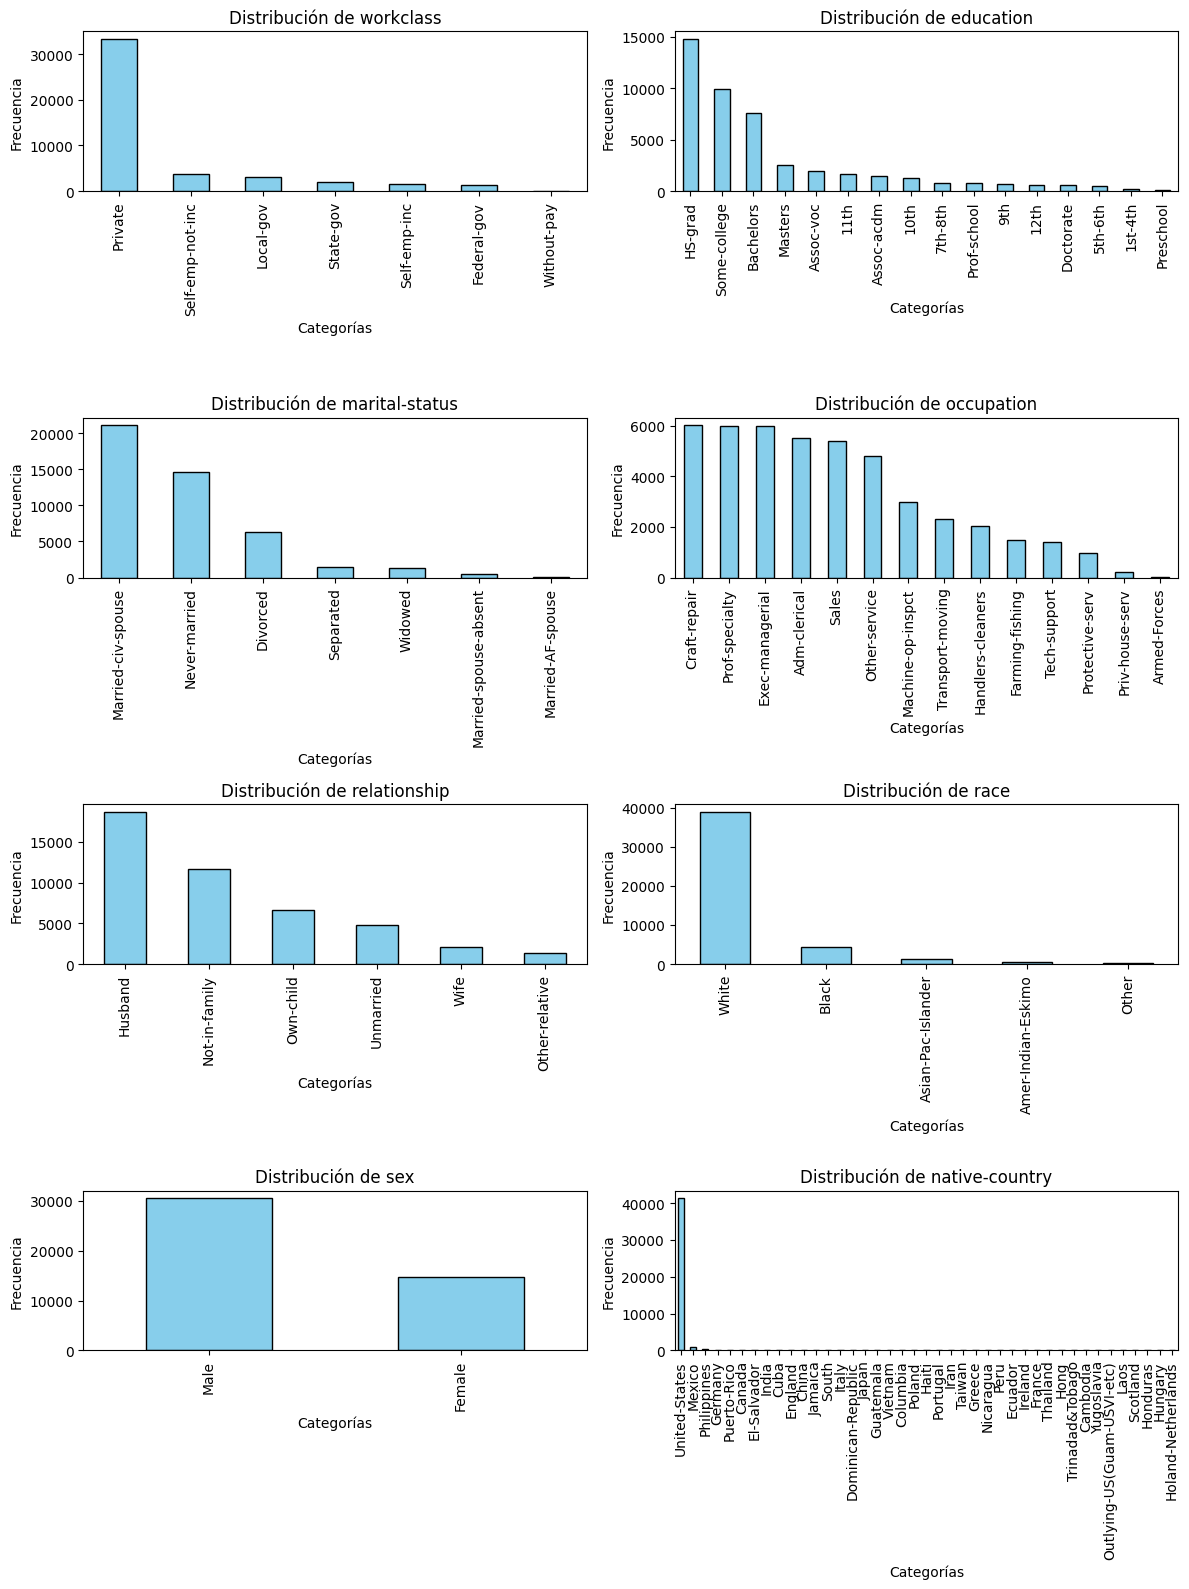

In [ ]:
def plot_categorical_histograms(df: pd.DataFrame, categorical_cols: list[str]) -> None:
    """
    Grafica histogramas (conteo de frecuencias) para columnas categóricas.

    Parámetros:
        df (pd.DataFrame): Dataset de entrada.
        categorical_cols (list[str]): Lista de nombres de columnas categóricas.
    """
    n_cols = 2  # número de gráficos por fila
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        if col not in df.columns:
            print(f"⚠️ Columna '{col}' no encontrada en el DataFrame. Se ignora.")
            continue

        df[col].value_counts(dropna=False).plot(
            kind="bar", ax=axes[i], color="skyblue", edgecolor="black"
        )
        axes[i].set_title(f"Distribución de {col}")
        axes[i].set_ylabel("Frecuencia")
        axes[i].set_xlabel("Categorías")

    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_categorical_histograms(X, classCat)


### Distribución de variables numéricas

En esta celda **se graficaron** histogramas con densidades para las variables numéricas (ya sin valores faltantes). **Se observa** que `education-num` es discreta y **presenta** varios picos entre 8 y 13, reflejando niveles educativos frecuentes. `fnlwgt` **muestra** una asimetría marcada a la derecha (cola larga), típica de un peso muestral. `hours-per-week` **se concentra** fuertemente cerca de 40 horas con una cola hacia valores altos. `age` **aparece** aproximadamente unimodal, con mayor densidad en la franja de 30–45 años y con colas moderadas. En `capital-gain` y `capital-loss` **predomina** el cero con **pocos** valores grandes aislados, lo que configura una distribución **cero-inflada** con outliers.

**Consecuencias para la confiabilidad del modelo.**
Estas formas distributivas afectan cómo un algoritmo aprende y qué tan estables son sus predicciones. La **cero-inflación** en `capital-gain` y `capital-loss` puede hacer que el modelo funcione casi como un detector binario de “tiene/no tiene” ganancia o pérdida de capital, por lo que, si esa señal es rara y muy informativa, las predicciones **tienden** a volverse frágiles fuera del patrón del conjunto. Basta un valor atípico para cambiar drásticamente la salida, y la **calibración** de probabilidades puede degradarse, sobre todo en los casos con cero. Los **outliers** (por ejemplo, ganancias de capital muy altas) **influyen** desproporcionadamente en modelos sensibles a la escala o a la varianza y **distorsionan** fronteras de decisión o coeficientes, generando errores impredecibles en ejemplos poco comunes. La fuerte **concentración** de `hours-per-week` alrededor de 40 implica que pequeñas diferencias numéricas aportan poca señal real, ya que el modelo **puede** sobreinterpretar ruido en ese rango y luego fallar cuando encuentra jornadas atípicas. En `education-num`, al ser una variable ordinal con saltos discretos, tratarla como magnitud estrictamente contínua **induce** la idea de que “pasar de 9 a 10” vale lo mismo que “pasar de 13 a 14”, lo cual **puede** introducir relaciones incorrectas con `income`. Finalmente, usar `fnlwgt` como predictor en lugar de reconocerlo como peso de diseño **mezcla** el proceso de muestreo con el fenómeno a predecir, donde el modelo **aprende** patrones del levantamiento de datos y su desempeño **pierde** confiabilidad al aplicarse en poblaciones o contextos distintos del survey original. En conjunto, estas características sugieren que un buen promedio global **puede ocultar** variabilidad de error y decisiones inestables en regiones raras del espacio numérico.


In [ ]:
non_class_cat = list(set(X.columns) - set(classCat))
non_class_cat

['education-num',
 'hours-per-week',
 'age',
 'fnlwgt',
 'capital-gain',
 'capital-loss']

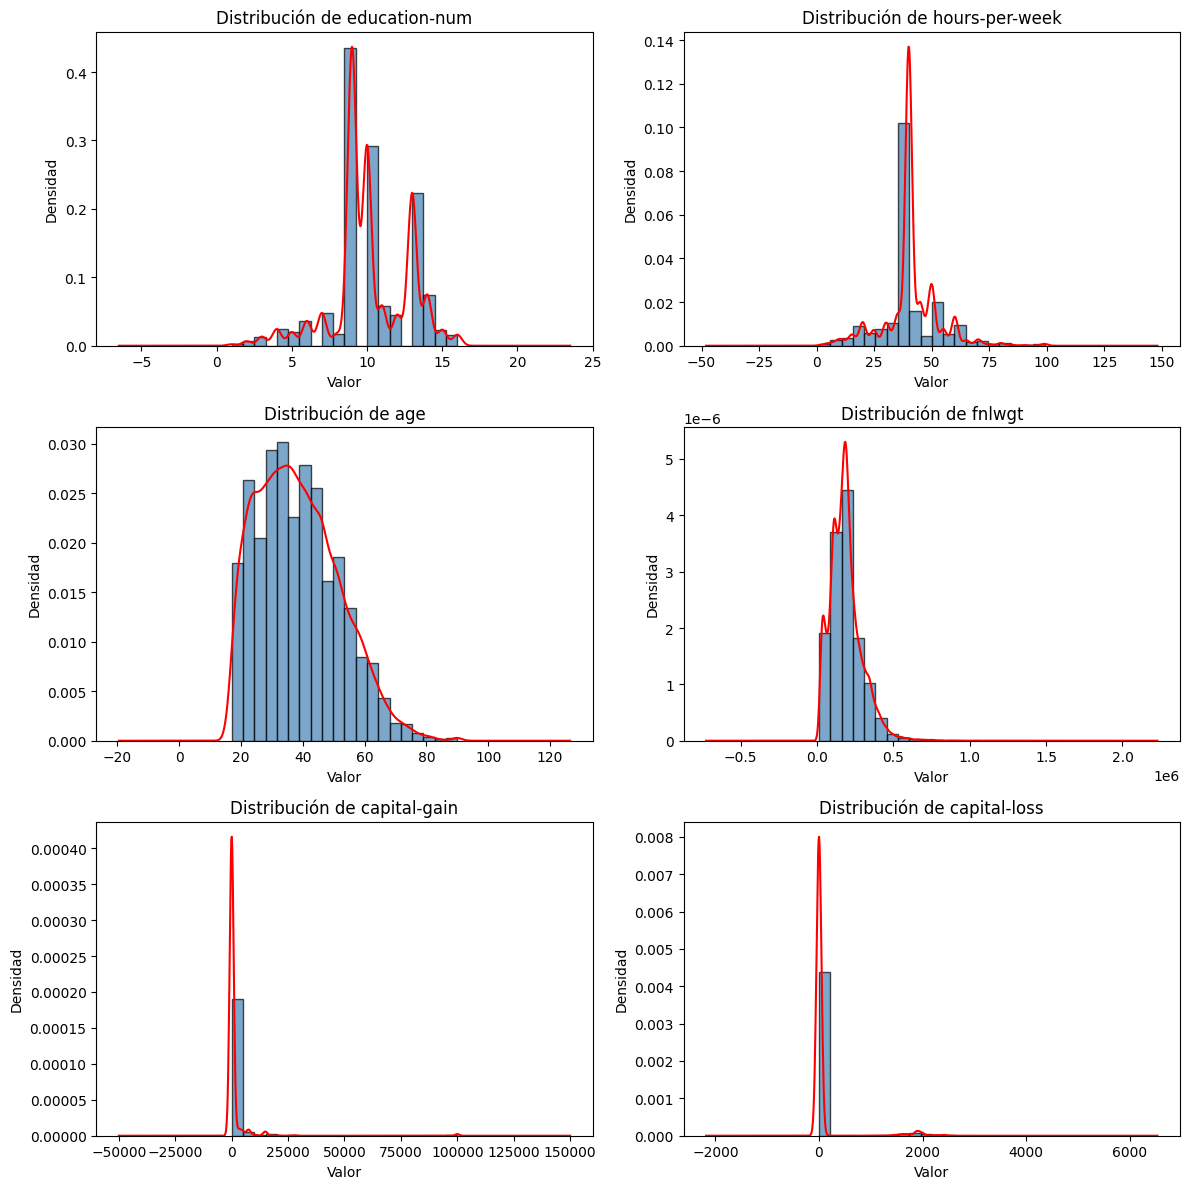

In [ ]:
def plot_numeric_distributions(df: pd.DataFrame, numeric_cols: list[str]) -> None:
    """
    Grafica distribuciones para columnas numéricas (histograma + curva de densidad).

    Parámetros:
        df (pd.DataFrame): Dataset de entrada.
        numeric_cols (list[str]): Lista de nombres de columnas numéricas.
    """
    n_cols = 2  # número de gráficos por fila
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        if col not in df.columns:
            print(f"⚠️ Columna '{col}' no encontrada en el DataFrame. Se ignora.")
            continue

        series = df[col].dropna()
        axes[i].hist(series, bins=20, color="steelblue", edgecolor="black", alpha=0.7, density=True)

        # Curva de densidad (estimación KDE con pandas)
        series.plot(kind="kde", ax=axes[i], color="red")

        axes[i].set_title(f"Distribución de {col}")
        axes[i].set_ylabel("Densidad")
        axes[i].set_xlabel("Valor")

    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
plot_numeric_distributions(X, non_class_cat)

### Distribución de la variable objetivo

En esta celda **se graficó** la distribución de `y`, donde **0** representa ingresos `<= 50K` USD/año y **1** ingresos `> 50K`. **Se observa** un claro desbalance, donde la clase 0 **concentra** la mayoría de los casos y la clase 1 es minoritaria (aprox. relación cercana a **3:1** según el conteo visual). Esta proporción fija el **riesgo base** del problema: un clasificador que siempre predijera 0 ya alcanzaría una precisión alta “de referencia”.

**Consecuencias para la confiabilidad del modelo.**
Con esta asimetría, el entrenamiento **tiende** a favorecer la clase mayoritaria y el umbral de decisión se **desplaza** hacia predecir 0; como resultado, el **recall** de la clase 1 suele **degradarse** y el modelo **pierde** sensibilidad justo donde más interesa (casos `> 50K`). La precisión promedio puede **resultar engañosa**: es posible obtener métricas globales altas aun con bajo desempeño en la clase minoritaria. Además, las probabilidades de salida para la clase 1 suelen quedar **subestimadas** (problemas de **calibración**), y la **varianza** de los errores crece en esa subpoblación, volviendo las predicciones **inestables** en los márgenes. Si la pertenencia a la clase 1 **correlaciona** con ciertos atributos (por ejemplo, educación, ocupación, sexo, raza o país), los errores **no** se distribuyen de forma uniforme, ya que se **acentúan** en perfiles menos representados, lo que afecta la **equidad** y la **confiabilidad** del sistema fuera del patrón dominante del dataset.


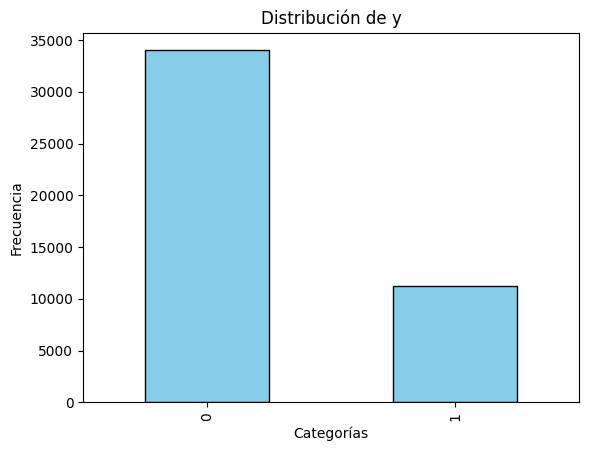

In [ ]:
# Graph numpy.ndarray named |y| values freq
def plot_y_hist(y: np.ndarray) -> None:
    """
    Grafica histogramas (conteo de frecuencias) para columnas categóricas.

    Parámetros:
        y (np.ndarray): Dataset de entrada.
    """
    y = pd.Series(y)
    y.value_counts(dropna=False).plot(
        kind="bar", color="skyblue", edgecolor="black"
    )
    plt.title(f"Distribución de y")
    plt.ylabel("Frecuencia")
    plt.xlabel("Categorías")
    plt.show()

plot_y_hist(np.ravel(y))



#### Se agrega todas las graficas al html

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Celda util · Helpers HTML/base64
# ─────────────────────────────────────────────────────────────────────────────
try:
    _fig_to_base64
except NameError:
    def _fig_to_base64(fig) -> str:
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight", dpi=160)
        buf.seek(0)
        b64 = base64.b64encode(buf.read()).decode("ascii")
        plt.close(fig)
        return b64

try:
    _ensure_html_report
except NameError:
    def _ensure_html_report(path: str, title: str = "Resultados de modelos") -> None:
        if not os.path.exists(path):
            with open(path, "w", encoding="utf-8") as f:
                f.write(f"""<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8" />
<title>{title}</title>
<style>
 body {{ font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; margin: 20px; }}
 h1 {{ margin-top: 0; }}
 h2 {{ border-bottom: 1px solid #ddd; padding-bottom: 4px; }}
 .metrics {{ border-collapse: collapse; margin: 8px 0; }}
 .metrics th, .metrics td {{ border: 1px solid #ddd; padding: 6px 10px; text-align: right; }}
 .grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(280px, 1fr)); gap: 16px; }}
 .card {{ border: 1px solid #eee; border-radius: 10px; padding: 12px; box-shadow: 0 1px 4px rgba(0,0,0,0.05); }}
 .muted {{ color: #666; font-size: 0.9em; }}
 pre {{ background: #f7f7f7; padding: 10px; border-radius: 8px; overflow: auto; }}
 img {{ max-width: 100%; height: auto; display: block; }}
 hr {{ border: none; border-top: 1px solid #eee; margin: 24px 0; }}
 table {{ border-collapse: collapse; }}
 td, th {{ border: 1px solid #ddd; padding: 6px 10px; }}
</style>
</head>
<body>
<h1>{title}</h1>
</body>
</html>""")

try:
    _append_section
except NameError:
    def _append_section(path: str, section_html: str) -> None:
        with open(path, "r+", encoding="utf-8") as f:
            html = f.read()
            marker = "</body>"
            insert_at = html.rfind(marker)
            if insert_at == -1:
                html += section_html
            else:
                html = html[:insert_at] + section_html + "\n" + html[insert_at:]
            f.seek(0); f.write(html); f.truncate()


In [ ]:
def make_y_hist_b64(y: np.ndarray, show: bool = False) -> str:
    y = pd.Series(np.ravel(y))
    fig = plt.figure(figsize=(5.5, 4))
    ax = fig.add_subplot(111)
    y.value_counts(dropna=False).plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")
    ax.set_title("Distribución de y")
    ax.set_ylabel("Frecuencia")
    ax.set_xlabel("Categorías")
    if show: plt.tight_layout(); plt.show()
    return _fig_to_base64(fig)

def make_categorical_grid_b64(df: pd.DataFrame, categorical_cols: list[str], show: bool = False) -> str:
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols or 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = np.array(axes).reshape(-1)
    for i, col in enumerate(categorical_cols[: len(axes)]):
        if col not in df.columns:
            axes[i].text(0.5, 0.5, f"'{col}' no encontrada", ha="center")
            axes[i].axis("off"); continue
        df[col].value_counts(dropna=False).plot(kind="bar", ax=axes[i], color="skyblue", edgecolor="black")
        axes[i].set_title(f"Distribución de {col}")
        axes[i].set_ylabel("Frecuencia")
        axes[i].set_xlabel("Categorías")
    for j in range(i + 1, len(axes)): axes[j].axis("off")
    plt.tight_layout()
    if show: plt.show()
    return _fig_to_base64(fig)

def make_numeric_grid_b64(df: pd.DataFrame, numeric_cols: list[str], show: bool = False) -> str:
    n_cols = 2
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols or 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = np.array(axes).reshape(-1)
    for i, col in enumerate(numeric_cols[: len(axes)]):
        if col not in df.columns:
            axes[i].text(0.5, 0.5, f"'{col}' no encontrada", ha="center")
            axes[i].axis("off"); continue
        s = df[col].dropna()
        axes[i].hist(s, bins=20, color="steelblue", edgecolor="black", alpha=0.7, density=True)
        s.plot(kind="kde", ax=axes[i], color="red")
        axes[i].set_title(f"Distribución de {col}")
        axes[i].set_ylabel("Densidad")
        axes[i].set_xlabel("Valor")
    for j in range(i + 1, len(axes)): axes[j].axis("off")
    plt.tight_layout()
    if show: plt.show()
    return _fig_to_base64(fig)

def export_dataset_variables_section(export_html_path: str, variables_df: pd.DataFrame) -> None:
    """Inserta la tabla 'adult.variables' en el HTML con un texto breve."""
    _ensure_html_report(export_html_path, title="Resultados de modelos")
    table_html = variables_df.to_html(index=False)
    sec = f"""
<hr/>
<h2>Adult (UCI) · Esquema de variables</h2>
<p class="muted">
Dataset con mezcla de atributos enteros y categóricos; la etiqueta es <code>income</code> (&gt;50K vs &le;50K).
</p>
<div class="card">{table_html}</div>
"""
    _append_section(export_html_path, sec)

def export_eda_distributions_section(
    export_html_path: str,
    *,
    y_img_b64: str,
    num_img_b64: str,
    cat_img_b64: str,
    y_desc_html: str,
    num_desc_html: str,
    cat_desc_html: str,
    section_title: str = "EDA · Distribuciones (objetivo, numéricas, categóricas)"
) -> None:
    """Inserta en el HTML una sección con 3 imágenes (y, num, cat) + descripciones."""
    _ensure_html_report(export_html_path, title="Resultados de modelos")
    sec = f"""
<hr/>
<h2>{section_title}</h2>

<div class="card">
  <h3>Distribución de la variable objetivo</h3>
  <div class="grid">
    <div class="card">
      <img alt="y distribution" src="data:image/png;base64,{y_img_b64}" />
    </div>
    <div class="card"><p>{y_desc_html}</p></div>
  </div>
</div>

<div class="card">
  <h3>Distribución de variables numéricas</h3>
  <div class="grid">
    <div class="card">
      <img alt="numeric distributions" src="data:image/png;base64,{num_img_b64}" />
    </div>
    <div class="card"><p>{num_desc_html}</p></div>
  </div>
</div>

<div class="card">
  <h3>Distribución de variables categóricas</h3>
  <div class="grid">
    <div class="card">
      <img alt="categorical distributions" src="data:image/png;base64,{cat_img_b64}" />
    </div>
    <div class="card"><p>{cat_desc_html}</p></div>
  </div>
</div>
"""
    _append_section(export_html_path, sec)


In [ ]:
try:
    export_dataset_variables_section("./report_modelos.html", adult.variables)
except Exception:
    pass

In [ ]:
y_img_b64   = make_y_hist_b64(np.ravel(y), show=False)
num_img_b64 = make_numeric_grid_b64(X, non_class_cat, show=False)
cat_img_b64 = make_categorical_grid_b64(X, classCat, show=False)


y_desc_html = """
<strong>Distribución de y.</strong> Aquí 0 ≡ “≤ 50K USD/año” y 1 ≡ “&gt; 50K USD/año”.
Se observa un claro desbalance (clase 0 mayoritaria), lo que sesga el umbral hacia predecir 0 y degrada el <em>recall</em> de la clase 1.
También tiende a subestimarse la probabilidad de la clase 1 (calibración) y a crecer la varianza del error en subpoblaciones poco representadas.
"""

num_desc_html = """
<strong>Numéricas.</strong> <code>education-num</code> es discreta con picos en 8–13; <code>fnlwgt</code> es asimétrica (peso muestral);
<code>hours-per-week</code> se concentra en ~40 h; <code>age</code> es unimodal (30–45); en <code>capital-gain/loss</code> domina el 0 (cero-inflación).
Estas formas afectan estabilidad y calibración: outliers y ceros masivos generan fronteras frágiles y probabilidades sesgadas en regiones raras.
"""

cat_desc_html = """
<strong>Categóricas.</strong> Predominan <em>Private</em> en <code>workclass</code>, <em>HS-grad/Some-college/Bachelors</em> en <code>education</code>,
<em>Married-civ-spouse</em> en <code>marital-status</code>, <em>Husband</em> en <code>relationship</code>, <em>White</em> en <code>race</code>,
<em>Male</em> en <code>sex</code> y <em>United-States</em> en <code>native-country</code>.
Las categorías raras elevan la varianza y pueden inducir errores desbalanceados entre grupos; además existen posibles <em>proxies</em> de atributos sensibles.
"""


export_eda_distributions_section(
    "./report_modelos.html",
    y_img_b64=y_img_b64,
    num_img_b64=num_img_b64,
    cat_img_b64=cat_img_b64,
    y_desc_html=y_desc_html,
    num_desc_html=num_desc_html,
    cat_desc_html=cat_desc_html,
    section_title="EDA · Distribuciones y notas de confiabilidad"
)


## Se desarrolla el modelo inicial

✂️ Celda 1 — Función para separar estratificadamente en train/valid/test

In [ ]:
def split_train_val_test(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    test_size: float = 0.20,
    val_size: float = 0.10,
    random_state: int = RANDOM_STATE,
    stratify: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    """
    Hace dos splits estratificados (si aplica):
      1) train_tmp vs test
      2) train vs val  (sobre train_tmp)
    Mantiene proporciones de clases si stratify=True y y es binaria/categórica.
    """
    strat = y if stratify else None

    X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    strat_tmp = y_train_tmp if stratify else None
    rel_val = val_size / (1.0 - test_size)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_tmp, y_train_tmp, test_size=rel_val, random_state=random_state, stratify=strat_tmp
    )

    return X_train, X_val, X_test, np.asarray(y_train), np.asarray(y_val), np.asarray(y_test)


### 🧱 Celda 2 — Construcción del pipeline (prepro + modelo XGBoost o Logístico)

In [ ]:
def build_pipeline(
    X_sample: pd.DataFrame,
    model: str = "xgb",
    xgb_params: Optional[Dict[str, Any]] = None,
    logreg_params: Optional[Dict[str, Any]] = None,
) -> Pipeline:
    """
    Detecta columnas numéricas vs categóricas, arma el ColumnTransformer y
    monta el clasificador pedido: 'xgb' (default) o 'logreg'.
    """
    cat_cols = list(X_sample.select_dtypes(include=["object", "category", "bool"]).columns)
    num_cols = [c for c in X_sample.columns if c not in cat_cols]
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )

    if model.lower() == "xgb":
        xgb_default = dict(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            n_jobs=-1,
            random_state=RANDOM_STATE,
        )
        xgb_default.update(xgb_params or {})
        clf = XGBClassifier(**xgb_default)

    elif model.lower() == "logreg":
        lr_default = dict(
            solver="lbfgs",
            max_iter=500,
            class_weight="balanced",
            random_state=RANDOM_STATE,
        )
        lr_default.update(logreg_params or {})
        clf = LogisticRegression(**lr_default)

    else:
        raise ValueError("model debe ser 'xgb' o 'logreg'")

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("clf", clf),
    ])
    return pipe


###🏃 Celda 3 — Entrenamiento + validación

In [ ]:
def _best_threshold_f1(y_true: np.ndarray, probas: np.ndarray) -> float:
    ps, rs, ths = precision_recall_curve(y_true, probas)
    f1s = 2 * (ps * rs) / (ps + rs + 1e-12)
    best_idx = np.nanargmax(f1s[:-1]) if len(ths) else 0
    return float(ths[best_idx]) if len(ths) else 0.5

def train_and_validate(
    pipe: Pipeline,
    X_train: pd.DataFrame, y_train: np.ndarray,
    X_val: pd.DataFrame,   y_val: np.ndarray,
    early_stopping_rounds: int = 50,
    verbose: bool = False
):
    pre: ColumnTransformer = pipe.named_steps["pre"]
    clf = pipe.named_steps["clf"]

    pre.fit(X_train, y_train)
    X_train_t = pre.transform(X_train)
    X_val_t   = pre.transform(X_val)

    if isinstance(clf, XGBClassifier):
        pos = int((y_train == 1).sum()); neg = int((y_train == 0).sum())
        if pos > 0:
            clf.set_params(scale_pos_weight=neg / max(pos, 1))
        clf.set_params(
            early_stopping_rounds=early_stopping_rounds,
        )

        clf.fit(
            X_train_t, y_train,
            eval_set=[(X_val_t, y_val)],
            verbose=verbose
        )
    else:
        clf.fit(X_train_t, y_train)

    val_proba = clf.predict_proba(X_val_t)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_val_t)
    best_thr = _best_threshold_f1(y_val, val_proba)
    val_pred = (val_proba >= best_thr).astype(int)

    val_metrics = {
        "accuracy": accuracy_score(y_val, val_pred),
        "precision": precision_score(y_val, val_pred, zero_division=0),
        "recall": recall_score(y_val, val_pred, zero_division=0),
        "f1": f1_score(y_val, val_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_val, val_proba),
        "pr_auc": average_precision_score(y_val, val_proba),
    }

    print("=== Validación ===")
    print(pd.Series(val_metrics).round(4))
    print("\nReporte de clasificación (val):")
    print(classification_report(y_val, val_pred, digits=4))

    pipe.named_steps["pre"] = pre
    pipe.named_steps["clf"] = clf
    return pipe, val_metrics, best_thr


###📊 Celda 4 — Evaluación en test y gráficas
#### Celda 4.1 · Gráfica: Matriz de confusión

In [ ]:
def plot_confusion_matrix(cm: np.ndarray, labels: Tuple[str, str] = ("0", "1")) -> None:
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Matriz de confusión (Test)")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_xticks([0, 1]); ax.set_xticklabels(labels)
    ax.set_yticks([0, 1]); ax.set_yticklabels(labels)


    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center")
    plt.show()


#### Celda 4.2 · Gráficas: ROC y Precision-Recall

In [ ]:
def plot_roc(y_true: np.ndarray, probas: np.ndarray) -> None:
    fpr, tpr, _ = roc_curve(y_true, probas)
    auc = roc_auc_score(y_true, probas)
    plt.figure(figsize=(5.5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC (Test)")
    plt.legend()
    plt.show()

def plot_pr(y_true: np.ndarray, probas: np.ndarray) -> None:
    p, r, _ = precision_recall_curve(y_true, probas)
    ap = average_precision_score(y_true, probas)
    plt.figure(figsize=(5.5, 4))
    plt.plot(r, p, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (Test)")
    plt.legend()
    plt.show()


#### Celda 4.3 · Importancias de características (XGBoost)

In [ ]:
def plot_feature_importances(pipe: Pipeline, top_k: int = 20) -> None:
    """Top-k importancias desde XGBoost alineadas a las columnas transformadas."""
    clf = pipe.named_steps["clf"]
    if not isinstance(clf, XGBClassifier):
        print("Importancias solo para XGBoost.")
        return

    pre: ColumnTransformer = pipe.named_steps["pre"]

    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = []
        if "num" in pre.named_transformers_:
            num_cols = pre.transformers_[0][2]
            feature_names += [f"num__{c}" for c in num_cols]
        if "cat" in pre.named_transformers_:
            cat_cols = pre.transformers_[1][2]
            ohe = pre.named_transformers_["cat"].named_steps["onehot"]
            cat_names = list(ohe.get_feature_names_out(cat_cols))
            feature_names += [f"cat__{c}" for c in cat_names]
        feature_names = np.array(feature_names, dtype=object)

    importances = clf.feature_importances_
    if len(importances) != len(feature_names):
        print("Aviso: tamaño de importancias no coincide con features transformadas.")
        return

    idx = np.argsort(importances)[::-1][:top_k]
    top_feats = feature_names[idx]
    top_vals = importances[idx]

    plt.figure(figsize=(7, max(3.5, 0.3 * top_k)))
    plt.barh(range(len(top_feats))[::-1], top_vals[::-1])
    plt.yticks(range(len(top_feats))[::-1], [str(f) for f in top_feats[::-1]])
    plt.xlabel("Importancia")
    plt.title(f"Top {top_k} características (XGBoost)")
    plt.tight_layout()
    plt.show()


#### Celda 4.4 · Contribuciones direccionales tipo SHAP (XGBoost)

In [ ]:
def _get_feature_name_mapping(pre: ColumnTransformer) -> dict[str, str]:
    """
    Mapea nombre de feature transformada -> feature original.
    Ej:
      'num__age' -> 'age'
      'cat__workclass_Private' -> 'workclass'
    """
    mapping: dict[str, str] = {}
    # Detectar columnas originales
    num_cols, cat_cols = [], []
    for name, trans, cols in pre.transformers_:
        if name == "num":
            num_cols = list(cols)
        elif name == "cat":
            cat_cols = list(cols)

    # Numéricas
    for c in num_cols:
        mapping[f"num__{c}"] = c

    # Categóricas (usar categorías reales del OHE para construir nombres exactos)
    ohe: OneHotEncoder = pre.named_transformers_["cat"].named_steps["onehot"]
    for col, cats in zip(cat_cols, ohe.categories_):
        for cat in cats:
            tf_name = f"cat__{col}_{cat}"
            mapping[tf_name] = col

    return mapping

def _to_str_list(names) -> list[str]:
    # pre.get_feature_names_out() devuelve un np.ndarray (dtype=object)
    # Lo convertimos a list[str] "puro".
    return [str(x) for x in list(names)]

def xgb_directional_contributions(
    pipe: Pipeline,
    X_ref: pd.DataFrame,
    top_k_features: int = 20,
    top_k_levels: int = 20,
):
    clf = pipe.named_steps["clf"]
    pre: ColumnTransformer = pipe.named_steps["pre"]

    if not isinstance(clf, XGBClassifier):
        print("Contribuciones direccionales: solo soportado para XGBoost.")
        return

    # 1) Transformar
    X_t = pre.transform(X_ref)

    # 2) Nombres de features transformadas
    feature_names = _to_str_list(pre.get_feature_names_out())

    if X_t.shape[1] != len(feature_names):
        print("Aviso: #cols transformadas no iguala a #feature_names_out.")
        return

    # 3) DMatrix con nombres como list[str]
    dmat = xgb.DMatrix(X_t, feature_names=feature_names)

    booster = clf.get_booster()
    contribs = booster.predict(dmat, pred_contribs=True)  # (n_samples, n_feats + 1)
    cols = feature_names + ["__bias__"]
    contribs_df = pd.DataFrame(contribs, columns=cols)

    # Estadísticos por feature transformada
    tf_stats = pd.DataFrame({
        "tf_feature": feature_names,
        "mean_abs_contrib": np.abs(contribs_df[feature_names]).mean(axis=0).values,
        "mean_contrib": contribs_df[feature_names].mean(axis=0).values,
        "std_contrib": contribs_df[feature_names].std(axis=0).values,
    })

    # Mapear a feature original y agregar
    mapping = _get_feature_name_mapping(pre)
    tf_stats["orig_feature"] = tf_stats["tf_feature"].map(mapping).fillna(tf_stats["tf_feature"])

    feat_stats = (tf_stats
                  .groupby("orig_feature", as_index=False)
                  .agg(mean_abs_contrib=("mean_abs_contrib", "sum"),
                       mean_contrib=("mean_contrib", "sum"))
                  .sort_values("mean_abs_contrib", ascending=False))

    # ── Plot 1: Magnitud (|contrib|) agrupada a nivel feature original
    topF = feat_stats.head(top_k_features)
    plt.figure(figsize=(7, max(3.5, 0.35 * len(topF))))
    plt.barh(range(len(topF))[::-1], topF["mean_abs_contrib"].values[::-1])
    plt.yticks(range(len(topF))[::-1], topF["orig_feature"].values[::-1])
    plt.xlabel("Importancia direccional (media de |contribución|)")
    plt.title(f"Top {len(topF)} features por magnitud de contribución (tipo SHAP)")
    plt.tight_layout()
    plt.show()

    # ── Plot 2: Dirección agregada (promedio con signo) a nivel feature original
    topS = (feat_stats
            .reindex(feat_stats["mean_contrib"].abs().sort_values(ascending=False).index)
            .head(top_k_features))
    plt.figure(figsize=(7, max(3.5, 0.35 * len(topS))))
    vals = topS["mean_contrib"].values
    y = range(len(topS))[::-1]
    plt.barh(y, vals[::-1])
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, topS["orig_feature"].values[::-1])
    plt.xlabel("Dirección agregada (promedio de contribución)")
    plt.title(f"Top {len(topS)} features por efecto neto (signo: sube/baja prob. clase 1)")
    plt.tight_layout()
    plt.show()

    # ── Niveles categóricos más influyentes (dummy-level)
    cat_levels = tf_stats[tf_stats["tf_feature"].str.startswith("cat__")].copy()
    # Construir etiqueta 'feature = categoría'
    def _level_label(s: str) -> str:
        # s ~ "cat__feature_category literal"
        s2 = s.replace("cat__", "", 1)
        feat, _, catval = s2.partition("_")
        return f"{feat} = {catval}"
    cat_levels["level"] = cat_levels["tf_feature"].map(_level_label)

    topL = cat_levels.reindex(cat_levels["mean_contrib"].abs().sort_values(ascending=False).index)\
                     .head(top_k_levels)

    plt.figure(figsize=(7.5, max(3.5, 0.35 * len(topL))))
    vals = topL["mean_contrib"].values
    y = range(len(topL))[::-1]
    plt.barh(y, vals[::-1])
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, topL["level"].values[::-1])
    plt.xlabel("Contribución promedio del nivel (signo)")
    plt.title(f"Top {len(topL)} niveles categóricos por efecto (tipo SHAP)")
    plt.tight_layout()
    plt.show()

    # Tablas resumen (para inspección rápida)
    display(feat_stats.head(top_k_features).assign(
        direction=np.where(feat_stats.head(top_k_features)["mean_contrib"] >= 0, "↑ sube prob(1)", "↓ baja prob(1)")
    ))
    display(topL[["level", "mean_contrib", "mean_abs_contrib"]])

    # Nota interpretativa
    print(
        "Notas:\n"
        "• Las contribuciones son en el espacio de margen (log-odds). Positivo ⇒ aumenta la prob. de clase 1; negativo ⇒ disminuye.\n"
        "• La última columna '__bias__' es el sesgo del modelo; la suma de contribuciones + bias = margen.\n"
        "• Para categóricas, agregamos dummies por feature para magnitud; el gráfico de niveles muestra efectos por categoría específica."
    )


#### Celda 4.5 · Evaluación en test

In [ ]:
def evaluate_on_test(
    pipe: Pipeline,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    threshold: float = 0.5,
    show_importances: bool = True,
    top_k_importances: int = 20,
    show_directional: bool = True,
    top_k_features_dir: int = 20,
    top_k_levels_dir: int = 20
) -> Dict[str, float]:
    """Evalúa en test, imprime métricas y grafica análisis."""
    probas = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["clf"], "predict_proba") else pipe.decision_function(X_test)
    preds = (probas >= threshold).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_test, probas),
        "pr_auc": average_precision_score(y_test, probas),
    }

    print("=== Test ===")
    print(pd.Series(metrics).round(4))
    print("\nReporte de clasificación (test):")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm, labels=("0", "1"))
    plot_roc(y_test, probas)
    plot_pr(y_test, probas)

    if show_importances:
        plot_feature_importances(pipe, top_k=top_k_importances)

    if show_directional:
        xgb_directional_contributions(
            pipe, X_test,
            top_k_features=top_k_features_dir,
            top_k_levels=top_k_levels_dir
        )

    return metrics

#### Celda 4.6 · Utilidades para exportar a HTML

In [ ]:
def _fig_to_base64(fig) -> str:
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=160)
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("ascii")
    plt.close(fig)
    return b64

def _ensure_html_report(path: str, title: str = "Resultados de modelos") -> None:
    if not os.path.exists(path):
        with open(path, "w", encoding="utf-8") as f:
            f.write(f"""<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="utf-8" />
<title>{title}</title>
<style>
 body {{ font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; margin: 20px; }}
 h1 {{ margin-top: 0; }}
 h2 {{ border-bottom: 1px solid #ddd; padding-bottom: 4px; }}
 .metrics {{ border-collapse: collapse; margin: 8px 0; }}
 .metrics th, .metrics td {{ border: 1px solid #ddd; padding: 6px 10px; text-align: right; }}
 .grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(280px, 1fr)); gap: 16px; }}
 .card {{ border: 1px solid #eee; border-radius: 10px; padding: 12px; box-shadow: 0 1px 4px rgba(0,0,0,0.05); }}
 .muted {{ color: #666; font-size: 0.9em; }}
 pre {{ background: #f7f7f7; padding: 10px; border-radius: 8px; overflow: auto; }}
 img {{ max-width: 100%; height: auto; display: block; }}
 hr {{ border: none; border-top: 1px solid #eee; margin: 24px 0; }}
 table {{ border-collapse: collapse; }}
 td, th {{ border: 1px solid #ddd; padding: 6px 10px; }}
</style>
</head>
<body>
<h1>{title}</h1>
<p class="muted">Generado: {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>
</body>
</html>""")

def _append_section(path: str, section_html: str) -> None:
    with open(path, "r+", encoding="utf-8") as f:
        html = f.read()
        marker = "</body>"
        insert_at = html.rfind(marker)
        if insert_at == -1:
            html += section_html
        else:
            html = html[:insert_at] + section_html + "\n" + html[insert_at:]
        f.seek(0); f.write(html); f.truncate()


#### Celda 4.7 · Utilidades SHAP-like para HTML

In [ ]:
def _shap_like_for_html(
    pipe: Pipeline,
    X_ref: pd.DataFrame,
    top_k_features: int = 20,
    top_k_levels: int = 20,
):
    """
    Calcula contribuciones tipo SHAP (TreeSHAP de XGBoost) y devuelve:
      - b64_mag: barra horizontal por magnitud (|contrib|) agregada a nivel feature original
      - b64_sign: barra horizontal por dirección (promedio con signo) a nivel feature original
      - b64_levels: barra horizontal por niveles categóricos con mayor efecto (signo)
      - topF_df: tabla top-k features (magnitud y signo)
      - topL_df: tabla top-k niveles categóricos
    No imprime nada.
    """
    clf: XGBClassifier = pipe.named_steps["clf"]
    pre: ColumnTransformer = pipe.named_steps["pre"]

    if not isinstance(clf, XGBClassifier):
        return None, None, None, None, None  # solo XGB soportado

    # Transformar
    X_t = pre.transform(X_ref)
    # Nombres de columnas transformadas
    try:
        feature_names = [str(x) for x in pre.get_feature_names_out()]
    except Exception:
        feature_names = []
        if "num" in pre.named_transformers_:
            num_cols = pre.transformers_[0][2]
            feature_names += [f"num__{c}" for c in num_cols]
        if "cat" in pre.named_transformers_:
            cat_cols = pre.transformers_[1][2]
            ohe = pre.named_transformers_["cat"].named_steps["onehot"]
            cat_names = list(ohe.get_feature_names_out(cat_cols))
            feature_names += [f"cat__{c}" for c in cat_names]
        feature_names = [str(x) for x in feature_names]

    # DMatrix con nombres
    dmat = xgb.DMatrix(X_t, feature_names=feature_names)

    booster = clf.get_booster()
    contribs = booster.predict(dmat, pred_contribs=True)  # (n, n_feats + 1)
    cols = feature_names + ["__bias__"]
    contribs_df = pd.DataFrame(contribs, columns=cols)

    # Stats por feature transformada
    tf_stats = pd.DataFrame({
        "tf_feature": feature_names,
        "mean_abs_contrib": np.abs(contribs_df[feature_names]).mean(axis=0).values,
        "mean_contrib": contribs_df[feature_names].mean(axis=0).values,
        "std_contrib": contribs_df[feature_names].std(axis=0).values,
    })

    # Mapear a feature original
    mapping = _get_feature_name_mapping(pre)
    tf_stats["orig_feature"] = tf_stats["tf_feature"].map(mapping).fillna(tf_stats["tf_feature"])

    feat_stats = (tf_stats
                  .groupby("orig_feature", as_index=False)
                  .agg(mean_abs_contrib=("mean_abs_contrib", "sum"),
                       mean_contrib=("mean_contrib", "sum"))
                  .sort_values("mean_abs_contrib", ascending=False))

    # Top-k features (magnitud y signo)
    topF = feat_stats.head(top_k_features).copy()
    topS = (feat_stats
            .reindex(feat_stats["mean_contrib"].abs().sort_values(ascending=False).index)
            .head(top_k_features).copy())

    # Niveles categóricos
    cat_levels = tf_stats[tf_stats["tf_feature"].str.startswith("cat__")].copy()
    def _level_label(s: str) -> str:
        s2 = s.replace("cat__", "", 1)
        feat, _, catval = s2.partition("_")
        return f"{feat} = {catval}"
    cat_levels["level"] = cat_levels["tf_feature"].map(_level_label)
    topL = (cat_levels
            .reindex(cat_levels["mean_contrib"].abs().sort_values(ascending=False).index)
            .head(top_k_levels).copy())

    # ===== Figuras (PNG base64) =====
    # 1) Magnitud
    fig1 = plt.figure(figsize=(7, max(3.5, 0.35 * len(topF))))
    ax1 = fig1.add_subplot(111)
    ax1.barh(range(len(topF))[::-1], topF["mean_abs_contrib"].values[::-1])
    ax1.set_yticks(range(len(topF))[::-1])
    ax1.set_yticklabels(topF["orig_feature"].values[::-1])
    ax1.set_xlabel("Importancia direccional (media de |contribución|)")
    ax1.set_title(f"Top {len(topF)} features por magnitud (tipo SHAP)")
    plt.tight_layout()
    b64_mag = _fig_to_base64(fig1)

    # 2) Dirección
    fig2 = plt.figure(figsize=(7, max(3.5, 0.35 * len(topS))))
    ax2 = fig2.add_subplot(111)
    y_ = range(len(topS))[::-1]
    ax2.barh(y_, topS["mean_contrib"].values[::-1])
    ax2.axvline(0, linestyle="--", linewidth=1)
    ax2.set_yticks(y_)
    ax2.set_yticklabels(topS["orig_feature"].values[::-1])
    ax2.set_xlabel("Dirección agregada (promedio de contribución)")
    ax2.set_title(f"Top {len(topS)} features por efecto neto (±)")
    plt.tight_layout()
    b64_sign = _fig_to_base64(fig2)

    # 3) Niveles categóricos (opcional)
    fig3 = plt.figure(figsize=(7.5, max(3.5, 0.35 * len(topL))))
    ax3 = fig3.add_subplot(111)
    yL = range(len(topL))[::-1]
    ax3.barh(yL, topL["mean_contrib"].values[::-1])
    ax3.axvline(0, linestyle="--", linewidth=1)
    ax3.set_yticks(yL)
    ax3.set_yticklabels(topL["level"].values[::-1])
    ax3.set_xlabel("Contribución promedio del nivel (signo)")
    ax3.set_title(f"Top {len(topL)} niveles categóricos (tipo SHAP)")
    plt.tight_layout()
    b64_levels = _fig_to_base64(fig3)

    # Tablas compactas
    topF_df = topF.assign(
        direction=np.where(topF["mean_contrib"] >= 0, "↑ sube prob(1)", "↓ baja prob(1)")
    )[["orig_feature", "mean_abs_contrib", "mean_contrib", "direction"]].reset_index(drop=True)

    topL_df = topL[["level", "mean_contrib", "mean_abs_contrib"]].reset_index(drop=True)

    return b64_mag, b64_sign, b64_levels, topF_df, topL_df


#### Celda 4.8 · Evaluación + exporte a HTML

In [ ]:
def evaluate_on_test_with_html(
    pipe: Pipeline,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    *,
    model_name: str,
    export_html_path: str,
    threshold: float = 0.5,
    include_importances: bool = True,
    include_directional_tables: bool = True,
    top_k_importances: int = 20,
    top_k_features_dir: int = 20,
    top_k_levels_dir: int = 20,
    show_plots: bool = True,
) -> Dict[str, float]:
    """
    Igual que antes, pero ahora agrega:
      • Gráficos SHAP-like (magnitud, signo y niveles) embebidos en el HTML.
      • Tablas top-k (features y niveles) si include_directional_tables=True.
    """
    # ── 1) Predicciones y métricas
    has_proba = hasattr(pipe.named_steps["clf"], "predict_proba")
    scores = pipe.predict_proba(X_test)[:, 1] if has_proba else pipe.decision_function(X_test)
    preds = (scores >= threshold).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_test, scores),
        "pr_auc": average_precision_score(y_test, scores),
    }
    cls_report = classification_report(y_test, preds, digits=4)

    # ── 2) CM, ROC y PR
    cm = confusion_matrix(y_test, preds)
    fig_cm, ax = plt.subplots(figsize=(4.5, 4))
    ax.imshow(cm, interpolation="nearest")
    ax.set_title("Matriz de confusión (Test)")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["0", "1"])
    ax.set_yticks([0, 1]); ax.set_yticklabels(["0", "1"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center")
    if show_plots: plt.show()
    b64_cm = _fig_to_base64(fig_cm)

    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    fig_roc = plt.figure(figsize=(5.5, 4)); axr = fig_roc.add_subplot(111)
    axr.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axr.plot([0, 1], [0, 1], linestyle="--")
    axr.set_xlabel("FPR"); axr.set_ylabel("TPR"); axr.set_title("ROC (Test)")
    axr.legend()
    if show_plots: plt.show()
    b64_roc = _fig_to_base64(fig_roc)

    p, r, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    fig_pr = plt.figure(figsize=(5.5, 4)); axp = fig_pr.add_subplot(111)
    axp.plot(r, p, label=f"AP = {ap:.3f}")
    axp.set_xlabel("Recall"); axp.set_ylabel("Precision"); axp.set_title("Precision-Recall (Test)")
    axp.legend()
    if show_plots: plt.show()
    b64_pr = _fig_to_base64(fig_pr)

    # ── 3) Importancias (XGB)
    b64_imp: Optional[str] = None
    clf = pipe.named_steps["clf"]
    if include_importances and isinstance(clf, XGBClassifier):
        pre: ColumnTransformer = pipe.named_steps["pre"]
        try:
            feature_names = pre.get_feature_names_out()
        except Exception:
            feature_names = []
            if "num" in pre.named_transformers_:
                num_cols = pre.transformers_[0][2]
                feature_names += [f"num__{c}" for c in num_cols]
            if "cat" in pre.named_transformers_:
                cat_cols = pre.transformers_[1][2]
                ohe = pre.named_transformers_["cat"].named_steps["onehot"]
                cat_names = list(ohe.get_feature_names_out(cat_cols))
                feature_names += [f"cat__{c}" for c in cat_names]
            feature_names = np.array(feature_names, dtype=object)

        importances = clf.feature_importances_
        if len(importances) == len(feature_names):
            idx = np.argsort(importances)[::-1][:top_k_importances]
            top_feats = feature_names[idx]
            top_vals = importances[idx]
            fig_imp = plt.figure(figsize=(7, max(3.5, 0.3 * top_k_importances)))
            axi = fig_imp.add_subplot(111)
            y = range(len(top_feats))[::-1]
            axi.barh(y, top_vals[::-1])
            axi.set_yticks(y); axi.set_yticklabels([str(f) for f in top_feats[::-1]])
            axi.set_xlabel("Importancia"); axi.set_title(f"Top {top_k_importances} características (XGBoost)")
            if show_plots: plt.tight_layout(); plt.show()
            b64_imp = _fig_to_base64(fig_imp)

    # ── 4) SHAP-like (TreeSHAP) para XGB: 3 gráficos + tablas
    b64_mag = b64_sign = b64_levels = None
    dir_tables_html = ""
    if isinstance(clf, XGBClassifier):
        b64_mag, b64_sign, b64_levels, topF_df, topL_df = _shap_like_for_html(
            pipe, X_test, top_k_features=top_k_features_dir, top_k_levels=top_k_levels_dir
        )
        if include_directional_tables and topF_df is not None:
            dir_tables_html = f"""
            <div class="card">
              <h3>Contribuciones direccionales (tipo SHAP)</h3>
              <p class="muted">Valores en margen (log-odds). El sesgo se incluye aparte.</p>
              <h4>Top {len(topF_df)} features (magnitud y signo)</h4>
              {topF_df.to_html(index=False)}
              <h4>Top {len(topL_df)} niveles categóricos</h4>
              {topL_df.to_html(index=False)}
            </div>
            """

    # ── 5) Construcción de la sección HTML
    metrics_df = pd.DataFrame([metrics]).round(4)
    metrics_df = metrics_df[["accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]]
    metrics_html = metrics_df.to_html(index=False, classes="metrics")

    imgs_html = f"""
    <div class="grid">
      <div class="card"><h3>Matriz de confusión</h3><img alt="Confusion Matrix" src="data:image/png;base64,{b64_cm}" /></div>
      <div class="card"><h3>ROC</h3><img alt="ROC" src="data:image/png;base64,{b64_roc}" /></div>
      <div class="card"><h3>Precision-Recall</h3><img alt="PR" src="data:image/png;base64,{b64_pr}" /></div>
      {f'<div class="card"><h3>Importancias (XGBoost)</h3><img alt="Importancias" src="data:image/png;base64,{b64_imp}" /></div>' if b64_imp else ''}
      {f'<div class="card"><h3>SHAP-like · magnitud</h3><img alt="SHAP magnitude" src="data:image/png;base64,{b64_mag}" /></div>' if b64_mag else ''}
      {f'<div class="card"><h3>SHAP-like · dirección</h3><img alt="SHAP signed" src="data:image/png;base64,{b64_sign}" /></div>' if b64_sign else ''}
      {f'<div class="card"><h3>SHAP-like · niveles</h3><img alt="SHAP levels" src="data:image/png;base64,{b64_levels}" /></div>' if b64_levels else ''}
    </div>
    """

    section = f"""
<hr/>
<h2>{model_name}</h2>
<p class="muted">Threshold usado: {threshold:.4f} · n_test={len(y_test)}</p>
<div class="card">
  <h3>Métricas (Test)</h3>
  {metrics_html}
</div>
<div class="card">
  <h3>Reporte de clasificación</h3>
  <pre>{cls_report}</pre>
</div>
{imgs_html}
{dir_tables_html}
"""

    _ensure_html_report(export_html_path, title="Resultados de modelos")
    _append_section(export_html_path, section)
    return metrics


### ▶️ Celda 5 — Uso end-to-end
Se armó un *pipeline* con preprocesamiento (one-hot para las categóricas y paso directo para las numéricas) y un **XGBoost** como clasificador. En *test* se obtuvieron probabilidades y, con umbral **0.5**, se generaron predicciones. Luego se calcularon métricas y se graficaron la matriz de confusión, las curvas **ROC** y **Precision-Recall**, además de dos vistas de explicabilidad: importancias del modelo y contribuciones haciendo uso de gráficas estilo shap (en log-odds). Luego se utilizó lo mismo para la evaluación **por subgrupos sensibles** (sexo, rangos de edad, raza, país, estado civil/relación).



=== Validación ===
accuracy     0.8700
precision    0.7257
recall       0.7645
f1           0.7446
roc_auc      0.9286
pr_auc       0.8396
dtype: float64

Reporte de clasificación (val):
              precision    recall  f1-score   support

           0     0.9210    0.9048    0.9128      3402
           1     0.7257    0.7645    0.7446      1121

    accuracy                         0.8700      4523
   macro avg     0.8233    0.8346    0.8287      4523
weighted avg     0.8726    0.8700    0.8711      4523


Umbral óptimo por F1 en validación: 0.6547


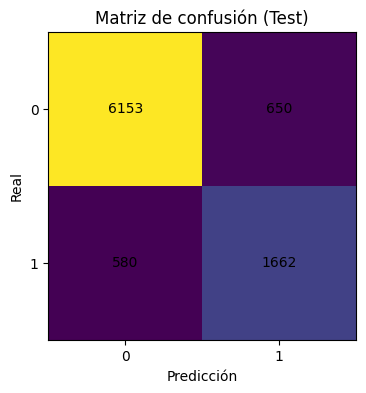

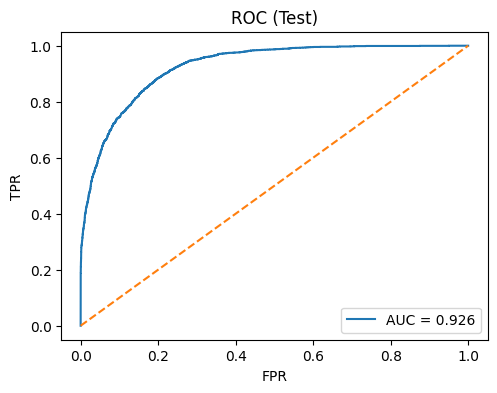

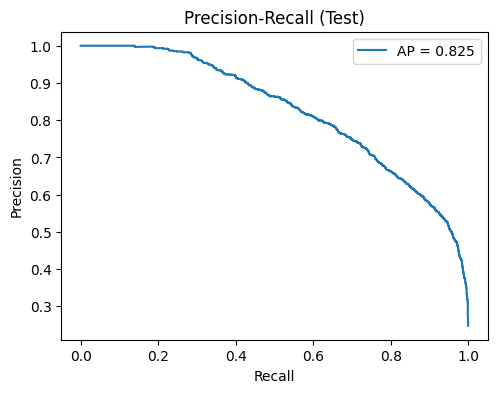

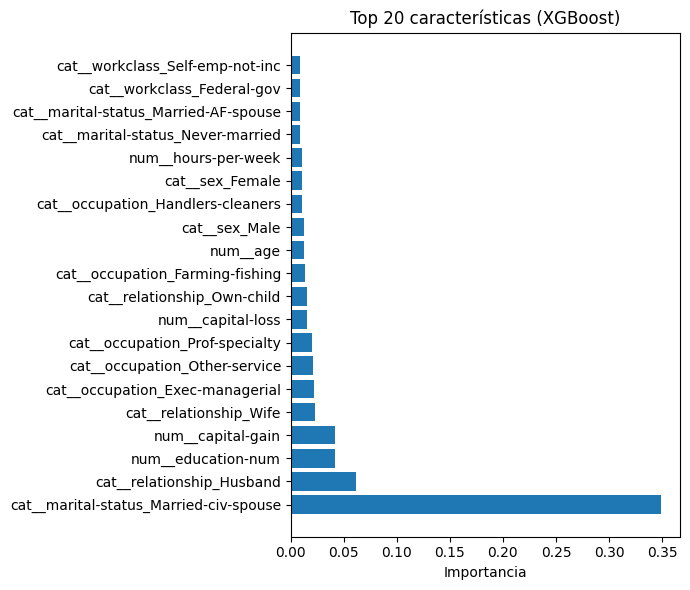


Resumen:
Validación: {'accuracy': 0.87, 'precision': 0.7257, 'recall': 0.7645, 'f1': 0.7446, 'roc_auc': np.float64(0.9286), 'pr_auc': np.float64(0.8396)}
Test: {'accuracy': 0.864, 'precision': 0.7189, 'recall': 0.7413, 'f1': 0.7299, 'roc_auc': np.float64(0.9259), 'pr_auc': np.float64(0.8251)}


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
    X, y, test_size=0.20, val_size=0.10, random_state=RANDOM_STATE, stratify=True
)

pipe = build_pipeline(
    X_sample=X_train,
    model="xgb",
)

pipe, val_metrics, best_thr = train_and_validate(
    pipe, X_train, y_train, X_val, y_val,
    early_stopping_rounds=50, verbose=False
)
print(f"\nUmbral óptimo por F1 en validación: {best_thr:.4f}")

test_metrics = evaluate_on_test_with_html(
    pipe, X_test, y_test,
    model_name="XGB · default",
    export_html_path="./report_modelos.html",
    threshold=best_thr,
    include_importances=True,
    include_directional_tables=True,
    top_k_importances=20,
    top_k_features_dir=20,
    top_k_levels_dir=20,
    show_plots=True,
)


print("\nResumen:")
print("Validación:", {k: round(v, 4) for k, v in val_metrics.items()})
print("Test:", {k: round(v, 4) for k, v in test_metrics.items()})


## Evaluación del modelo (global y por grupos sensibles)

### **Resultados globales**
En *test* el modelo rindió **accuracy 0.864**, **precision 0.7189**, **recall 0.7413**, **F1 0.7299**, **ROC-AUC 0.9259** y **PR-AUC 0.8251**. La ROC sugiere buen poder de ordenamiento y la PR se mantiene sólida pese al desbalance. La matriz de confusión muestra **650** falsos positivos y **580** falsos negativos, y cuál “pesa” más depende del uso que se le dé al sistema.


### **Evaluación segmentada**
Para cada grupo sensible se volvieron a calcular **precision**, **recall**, **F1**, la **tasa de verdaderos positivos**, la **precision por grupo** (paridad predictiva) y la **tasa de positivos predichos** (paridad demográfica). ¿Cómo leerlo? Si un grupo tiene **TPR** más bajo, el modelo **se le escapan** más casos verdaderamente positivos allí, por lo que, si su **precision** cae, hay más “falsas alarmas”. Además, si la proporción de positivos predichos cambia mucho entre grupos, el sistema **decide distinto** según quién sea la persona, incluso con señales parecidas. Las curvas ROC/PR por subgrupo ayudan a ver si el problema es de **umbral** o de **ranking**.


### **Lo que cuentan las explicaciones, visto con las distribuciones**

Primero lo esencial: estas contribuciones (tipo SHAP, en **log-odds**) dicen
qué tanto cada variable sube o baja el puntaje hacia `y=1` (`> 50K`). Signo negativo ⇒ baja la probabilidad, y positivo ⇒ sube. Es de esperarse, ya que es cómo el modelo está usando las señales que vio.

**Lo que más pesa.**
Es claro que **`marital-status`** es la señal dominante, con mayor magnitud (≈ **1.13**) y efecto neto **negativo** (≈ **-0.41**). **`age`** también pesa bastante y va en la misma dirección (≈ **-0.35**). Luego vienen **`occupation`**, **`capital-gain`**, **`education-num`**, **`hours-per-week`** y **`relationship`**, todas con promedio **negativo**. Llama la atención que casi todo el “top” empuje hacia abajo, ya que con la data desbalanceada, las combinaciones **típicas** del conjunto suelen ir a `<= 50K`, y las que suben a `> 50K` son menos frecuentes.

**Niveles específicos (las categorías que afectan la decisión).**

* **`marital-status = Married-civ-spouse`** es el nivel con mayor descenso promedio (≈ **-0.378**).
* **`relationship = Own-child`** también baja bastante el puntaje.
* En **ocupación**, varios niveles (p. ej. *Other-service*, *Prof-specialty*, *Exec-managerial*) aparecen con efecto medio **ligeramente** negativo.
* En **sexo**, **`Female`** tiene contribución media más negativa que **`Male`** (≈ **-0.0275** vs **-0.0093**).
* En **raza**, **`Black`** y **`White`** muestran promedios negativos (más marcado en *Black* en la tabla).

**Cómo encaja con las formas de las variables numéricas.**

* **`capital-gain` / `capital-loss`** están **cero-infladas**, donde casi todo es **0** y pocos valores son grandes. Por eso el **promedio** sale negativo y, aun así, cuando hay una ganancia real, el efecto individual suele **empujar fuerte hacia arriba**.
* **`hours-per-week`** se apila alrededor de **40**, con pequeñas variaciones que aportan poca señal y el promedio queda un poco hacia abajo si no viene con otras “pruebas” a favor.
* **`education-num`** es **ordinal**. Tratarla como continua puede diluir el valor de los niveles altos si son minoritarios junto con otras variables pro-`> 50K`.
* **`fnlwgt`** es peso muestral. Meterlo como predictor mezcla un poco el **diseño del survey** con el fenómeno. Su efecto medio es pequeño, pero conviene tenerlo presente si se piensa generalizar.

**Combinando con las distribuciones y el desbalance.**

En los gráficos de categóricas se vio predominio de **Male**, **White**, **United-States**, **Husband**, **Private**, etc., y en la **y** la clase **0** domina (\~3:1). Con esto, el modelo “aprende” sobre todo el **perfil mayoritario**, y el **promedio** de contribuciones termina **tirando a negativo** para `> 50K`. Las categorías raras (países u oficios con poca muestra) aportan señal **inestable**, así que sus promedios también suelen ir hacia abajo, no porque “no puedan” ser `> 50K`, sino porque **hay pocos ejemplos** así en los datos.

**Detalles que llaman la atención.**

* Que **`Married-civ-spouse`** sea el mayor descenso promedio es  **inesperado** a primera vista. Probablemente refleja **combinaciones** con *relationship*, *sex*, *hours-per-week* y *occupation* que, en esta muestra, aparecen más con `<= 50K`.
* Con **`Female`** más negativo que **`Male`**, es normal el **recall** o la **precision** por sexo muestran brechas, ya que el puntaje parte un poco **más abajo** para ese grupo, a igualdad de lo demás.
* En **`capital-gain`**, aunque el promedio sea negativo por la masa en cero, **un valor positivo real** puede **dar vuelta** la predicción de un caso puntual.
* En **edad**, el efecto neto negativo sugiere que ciertos rangos, si no traen de la mano ocupaciones/educaciones bien pagadas, **no** se asocian con `> 50K` en este dataset.




## Creación de nuevo modelo.

### Propuesta de mitigación

Para bajar brechas entre grupos sin cambiar el set de variables ni recolectar datos nuevos ahora mismo. Se propusó:

---

#### 1) Re-pesado simple

* **Qué:** usar `sample_weight = fnlwgt` y ajustar el desbalance con `class_weight` o `scale_pos_weight ≈ N_neg / N_pos`.
* **Por qué:** la clase `>50K` es minoritaria y el dataset viene de un *survey*, por lo que el re-pesado corrige ambas cosas sin tocar *features*.
* **Cómo:** mantener el *pipeline* y pasar los pesos al `fit`. Reportar métricas **por grupo** antes/después.
* **Esperado:** mayor *recall* de la clase 1 y menos dependencia del perfil mayoritario.

---

#### 2) Post-proceso “barato”, con umbrales y calibración **por grupo**

* **Qué:** fijar **umbrales por grupo** (p. ej., igualar *recall* entre sexos/razas/edades) y **calibrar** las probabilidades por grupo (isotónica o Platt sobre validación).
* **Por qué:** no requiere reentrenar y suele cerrar brechas rápido cuando el modelo ya ranquea bien (nuestro ROC/PR lo sugiere).
* **Cómo:** con el set de validación, para cada grupo elegir el umbral que cumpla la meta (igualdad de *recall* o de *precision*). Guardar esos umbrales y las funciones de calibración y aplicarlos en inferencia.
* **Esperado:** *recall/precision* más parejos y mejores probabilidades (menor ECE/Brier) por subpoblación.

---

#### 3) **Constraints** en XGBoost

* **Qué:**

  * **Monotone constraints:** que la prob. **no baje** al subir `education-num` o `hours-per-week` (cuando todo lo demás queda igual).
  * **Interaction constraints:** **limitar** interacciones complejas con variables sensibles (sexo, raza, estado civil/relación).
* **Por qué:** evita relaciones contraintuitivas y reduce que el modelo “combine” *proxies* sensibles con todo lo demás.
* **Cómo:** definir `monotone_constraints` para numéricas y usar `interaction_constraints` para separar dummies sensibles del resto, manteniendo sus efectos lineales.
* **Esperado:** decisiones más estables y menos dependencia de combinaciones espurias.

---

### Cómo se evaluará

* **Métricas por grupo:** *recall/TPR*, *precision/PPV*, *FPR/FNR*, F1, **PR-AUC**, **calibración** (ECE/Brier, reliability plots).
* **Criterio de éxito:** reducir brechas de TPR/PPV entre grupos (con intervalos de confianza) **sin** perder AUC global de forma significativa.
* **Trazabilidad:** guardar umbrales por grupo, pesos usados y *seeds*; comparar **antes vs. después** en el mismo *split*.

> En resumen, re-pesar para que el entrenamiento “escuche” a la minoría, ajustar y calibrar **por grupo** para decidir mejor, y poner **constraints** suaves en XGBoost para que el modelo no se vaya por atajos raros.


#### Celda 6.1 · Utilidades de re-pesado

In [ ]:
def compute_scale_pos_weight(y: np.ndarray, sample_weight: Optional[np.ndarray] = None) -> float:
    y = np.asarray(y).ravel()
    if sample_weight is None:
        pos = (y == 1).sum()
        neg = (y != 1).sum()
    else:
        w = np.asarray(sample_weight).ravel()
        pos = w[y == 1].sum()
        neg = w[y != 1].sum()
    return float(neg / max(pos, 1e-12))

def extract_sample_weight(X_df: pd.DataFrame, weight_col: str = "fnlwgt") -> np.ndarray:
    if weight_col not in X_df.columns:
        raise ValueError(f"No se encontró la columna de pesos '{weight_col}' en X.")
    w = X_df[weight_col].to_numpy(dtype=float)
    return w


#### Celda 6.2 · Constraints para XGBoost

In [ ]:
def _get_transformed_feature_names(pre: ColumnTransformer) -> list[str]:
    return [str(x) for x in pre.get_feature_names_out()]

def build_monotone_dict(pre: ColumnTransformer, monotone_map: Dict[str, int]) -> Dict[str, int]:
    """
    Devuelve un dict {nombre_col_transformada: +1/-1/0} para XGBoost,
    usando nombres reales (recomendado por la doc). Ej.: {"num__hours-per-week": +1}
    """
    names = _get_transformed_feature_names(pre)
    mono: Dict[str, int] = {}
    for n in names:
        if n.startswith("num__"):
            base = n.replace("num__", "", 1)
            if base in monotone_map:
                mono[n] = int(monotone_map[base])
    return mono

def build_interaction_constraints_names(pre: ColumnTransformer, sensitive_cols: List[str]) -> List[List[str]]:
    """
    Limita interacciones con variables sensibles usando NOMBRES (no índices).
    Cada feature sensible (todas sus dummies/num) se pone en su PROPIO grupo.
    El resto va en un grupo grande. Con esto, ramas con sensibles no interactúan
    con el resto (según regla de XGBoost para interaction_constraints).
    """
    names = _get_transformed_feature_names(pre)

    def names_for_feature(orig: str) -> List[str]:
        pref_num = f"num__{orig}"
        pref_cat = f"cat__{orig}_"
        out = [n for n in names if n == pref_num or n.startswith(pref_cat)]
        return out

    sens_groups: List[List[str]] = []
    sens_name_set = set()
    for s in sensitive_cols:
        grp = names_for_feature(s)
        if grp:
            sens_groups.append(grp)
            sens_name_set.update(grp)

    rest = [n for n in names if n not in sens_name_set]
    groups = sens_groups + ([rest] if rest else [])
    return groups

def apply_constraints_to_clf(clf: XGBClassifier, pre: ColumnTransformer,
                             monotone_map: Dict[str, int],
                             sensitive_cols: List[str]) -> XGBClassifier:
    # Monotonicidad por NOMBRE (dict). Doc oficial sugiere nombres cuando hay DataFrame.
    mono_dict = build_monotone_dict(pre, monotone_map)
    # Interacciones por NOMBRE (listas de listas de str)
    inter_names = build_interaction_constraints_names(pre, sensitive_cols)
    clf.set_params(monotone_constraints=mono_dict, interaction_constraints=inter_names)
    return clf


#### Celda 6.3 · Entrenamiento con pesos y threshold óptimo por F1

In [ ]:
def _best_threshold_by_f1(y_true: np.ndarray, scores: np.ndarray,
                          sample_weight: Optional[np.ndarray] = None) -> float:
    y_true = np.asarray(y_true).ravel()
    scores = np.asarray(scores).ravel()
    p, r, thr = precision_recall_curve(y_true, scores)
    if thr.size == 0:
        return 0.5
    best_thr, best_f1 = 0.5, -1.0
    for t in thr:
        preds = (scores >= t).astype(int)
        f1 = f1_score(y_true, preds, sample_weight=sample_weight, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(t)
    return float(best_thr)

def train_and_validate_weighted(
    pipe: Pipeline,
    X_train: pd.DataFrame, y_train: np.ndarray, w_train: Optional[np.ndarray],
    X_val: pd.DataFrame,   y_val: np.ndarray,   w_val:   Optional[np.ndarray],
    early_stopping_rounds: int = 50,  # definido en el constructor del XGBClassifier
    verbose: bool = False
) -> Tuple[Pipeline, Dict[str, float], float]:
    clf = pipe.named_steps["clf"]
    pre: ColumnTransformer = pipe.named_steps["pre"]

    if not hasattr(pre, "transformers_"):
        pre.fit(X_train, y_train)

    # ⚠️ eval_set ya transformado para el estimador final
    X_val_t = pre.transform(X_val)

    if isinstance(clf, XGBClassifier):
        fit_params = {
            "clf__sample_weight": w_train,
            "clf__eval_set": [(X_val_t, y_val)],
            "clf__sample_weight_eval_set": [w_val] if w_val is not None else None,
            "clf__verbose": False,  # ← silencia los prints por iteración
        }
        fit_params = {k: v for k, v in fit_params.items() if v is not None}
        pipe.fit(X_train, y_train, **fit_params)
    else:
        pipe.fit(X_train, y_train, **({"clf__sample_weight": w_train} if w_train is not None else {}))

    val_scores = pipe.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else pipe.decision_function(X_val)
    best_thr = _best_threshold_by_f1(y_val, val_scores, sample_weight=w_val)

    preds_val = (val_scores >= best_thr).astype(int)
    val_metrics = {
        "accuracy": accuracy_score(y_val, preds_val),
        "precision": precision_score(y_val, preds_val, zero_division=0),
        "recall": recall_score(y_val, preds_val, zero_division=0),
        "f1": f1_score(y_val, preds_val, zero_division=0),
        "roc_auc": roc_auc_score(y_val, val_scores),
        "pr_auc": average_precision_score(y_val, val_scores),
    }
    return pipe, val_metrics, best_thr


#### Celda 6.4 · Post-proceso barato con calibración por grupo (isotónica)

In [ ]:
def fit_group_calibrators(
    y_val: np.ndarray,
    scores_val: np.ndarray,
    group_val: pd.Series,
    method: str = "isotonic"  # "isotonic" | "platt"
) -> Dict[str, object]:
    calibrators: Dict[str, object] = {}
    y_val = np.asarray(y_val).ravel()
    scores_val = np.asarray(scores_val).ravel()
    groups = pd.Series(group_val).reset_index(drop=True)  # ← clave: índices 0..n-1

    if not (len(groups) == len(y_val) == len(scores_val)):
        raise ValueError("Longitudes distintas entre grupos, y y scores.")

    for g, idx in groups.groupby(groups).groups.items():
        y_g = y_val[idx]
        s_g = scores_val[idx]
        if method == "isotonic":
            cal = IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds="clip")
            cal.fit(s_g, y_g)
        else:
            cal = LogisticRegression(solver="lbfgs")
            cal.fit(s_g.reshape(-1, 1), y_g)
        calibrators[g] = cal
    return calibrators

def apply_group_calibration(scores: np.ndarray, groups: pd.Series,
                            calibrators: Dict[str, object]) -> np.ndarray:
    scores = np.asarray(scores).ravel()
    groups = pd.Series(groups).reset_index(drop=True)  # ← posicional
    if len(groups) != len(scores):
        raise ValueError("Longitudes distintas entre grupos y scores.")

    out = np.empty_like(scores, dtype=float)
    for g, idx in groups.groupby(groups).groups.items():
        s = scores[idx]
        cal = calibrators.get(g, None)
        if cal is None:
            out[idx] = s
        else:
            if isinstance(cal, IsotonicRegression):
                out[idx] = cal.transform(s)
            else:
                out[idx] = cal.predict_proba(s.reshape(-1, 1))[:, 1]
    return out


#### Celda 6.5 · Post-proceso barato con umbrales por grupo (igualar recall y precision)

In [ ]:
def _metric_at_threshold(y_true: np.ndarray, scores: np.ndarray, thr: float, metric: str) -> float:
    preds = (scores >= thr).astype(int)
    if metric == "recall":
        return recall_score(y_true, preds, zero_division=0)
    elif metric == "precision":
        return precision_score(y_true, preds, zero_division=0)
    else:
        raise ValueError("metric debe ser 'recall' o 'precision'.")

def fit_group_thresholds_equalize(
    y_val: np.ndarray,
    scores_val: np.ndarray,
    group_val: pd.Series,
    metric: str = "recall",
    base_threshold: float = 0.5,
    target_value: Optional[float] = None
) -> Dict[str, float]:
    y_val = np.asarray(y_val).ravel()
    scores_val = np.asarray(scores_val).ravel()
    groups = pd.Series(group_val).reset_index(drop=True)  # ← posicional

    if not (len(groups) == len(y_val) == len(scores_val)):
        raise ValueError("Longitudes distintas entre grupos, y y scores.")

    if target_value is None:
        target_value = _metric_at_threshold(y_val, scores_val, base_threshold, metric)

    thresholds_by_group: Dict[str, float] = {}
    for g, idx in groups.groupby(groups).groups.items():
        y_g = y_val[idx]
        s_g = scores_val[idx]
        p, r, thr = precision_recall_curve(y_g, s_g)
        if thr.size == 0:
            thresholds_by_group[g] = base_threshold
            continue
        metric_values = r[1:] if metric == "recall" else p[1:]
        j = int(np.argmin(np.abs(metric_values - target_value)))
        thresholds_by_group[g] = float(thr[j])
    return thresholds_by_group

def apply_group_thresholds(scores: np.ndarray, groups: pd.Series,
                           thresholds_by_group: Dict[str, float],
                           default_threshold: float = 0.5) -> np.ndarray:
    scores = np.asarray(scores).ravel()
    groups = pd.Series(groups).reset_index(drop=True)  # ← posicional
    if len(groups) != len(scores):
        raise ValueError("Longitudes distintas entre grupos y scores.")

    preds = np.zeros_like(scores, dtype=int)
    for g, idx in groups.groupby(groups).groups.items():
        t = thresholds_by_group.get(g, default_threshold)
        preds[idx] = (scores[idx] >= t).astype(int)
    return preds


#### Celda 6.6 · Evaluación agrupada y exporte HTML

In [ ]:
def _append_section(path: str, section_html: str) -> None:
    with open(path, "r+", encoding="utf-8") as f:
        html = f.read()
        marker = "</body>"
        i = html.rfind(marker)
        html = (html + section_html) if i == -1 else (html[:i] + section_html + "\n" + html[i:])
        f.seek(0); f.write(html); f.truncate()

def export_group_postprocess_section(
    export_html_path: str,
    model_name: str,
    metric_equalized: str,
    overall_before: Dict[str, float],
    overall_after: Dict[str, float],
    per_group_df: pd.DataFrame
) -> None:
    per_group_html = per_group_df.to_html(index=False)
    sec = f"""
<hr/>
<h2>{model_name} · Post-proceso por grupo</h2>
<p class="muted">Métrica igualada: <b>{metric_equalized}</b></p>
<div class="card">
  <h3>Métricas globales</h3>
  <table class="metrics">
    <tr><th></th><th>accuracy</th><th>precision</th><th>recall</th><th>f1</th><th>roc_auc</th><th>pr_auc</th></tr>
    <tr><td>Antes</td><td>{overall_before['accuracy']:.4f}</td><td>{overall_before['precision']:.4f}</td><td>{overall_before['recall']:.4f}</td><td>{overall_before['f1']:.4f}</td><td>{overall_before['roc_auc']:.4f}</td><td>{overall_before['pr_auc']:.4f}</td></tr>
    <tr><td>Después</td><td>{overall_after['accuracy']:.4f}</td><td>{overall_after['precision']:.4f}</td><td>{overall_after['recall']:.4f}</td><td>{overall_after['f1']:.4f}</td><td>{overall_after['roc_auc']:.4f}</td><td>{overall_after['pr_auc']:.4f}</td></tr>
  </table>
</div>
<div class="card">
  <h3>Tabla por grupo (después de calibrar + umbrales)</h3>
  {per_group_html}
</div>
"""
    _append_section(export_html_path, sec)

def _metrics_dict(y_true: np.ndarray, preds: np.ndarray, scores: np.ndarray) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y_true, preds),
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds, zero_division=0),
        "f1": f1_score(y_true, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_true, scores),
        "pr_auc": average_precision_score(y_true, scores),
    }


#### Celda 6.7 · Ejecución con re-pesado, constraints y post-proceso por grupo

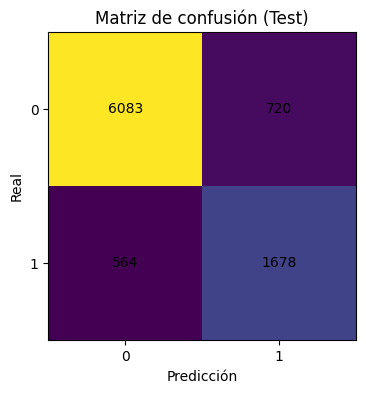

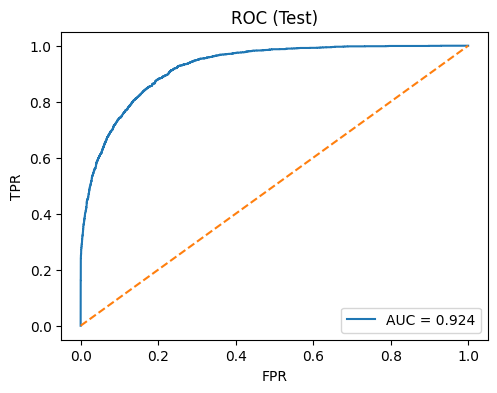

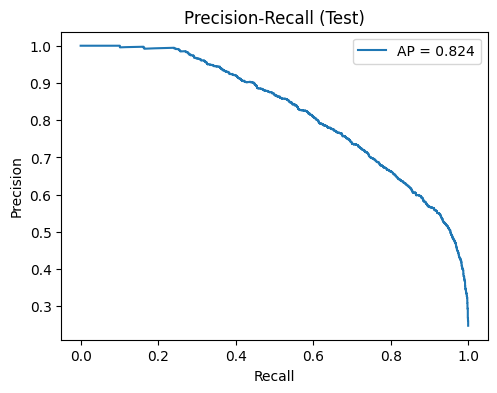

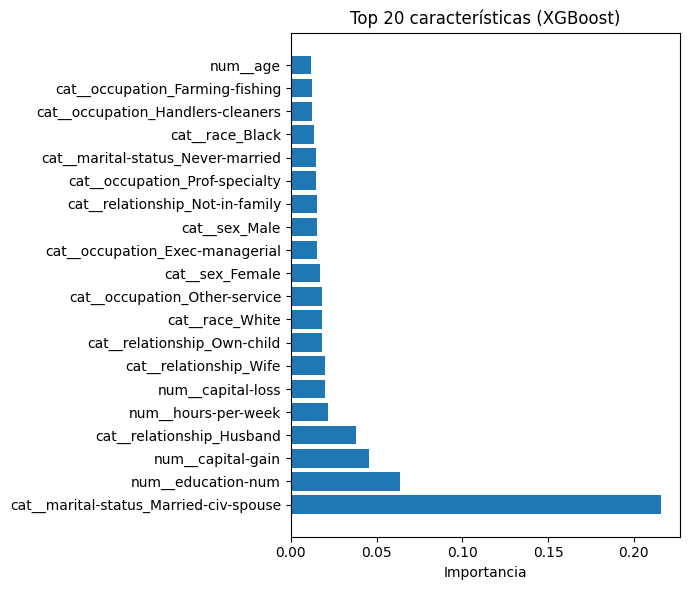

In [ ]:
# 1) Pesos y scale_pos_weight
w_train = extract_sample_weight(X_train, "fnlwgt")
w_val   = extract_sample_weight(X_val,   "fnlwgt")

spw = compute_scale_pos_weight(y_train, sample_weight=w_train)

# 2) Armar pipeline XGB con scale_pos_weight y early stopping en el CONSTRUCTOR
#    + silenciar salida del booster
pipe = build_pipeline(
    X_sample=X_train,
    model="xgb",
    xgb_params={
        "scale_pos_weight": spw,
        "early_stopping_rounds": 50,
        "verbosity": 0,   # silencio global del booster
    }
)

# Forzar OHE denso para permitir salida pandas
try:
    pipe.set_params(pre__cat__onehot__sparse_output=False)
except ValueError:
    pipe.set_params(pre__cat__onehot__sparse=False)

# 3) Asegurar salida pandas con nombres
pre: ColumnTransformer = pipe.named_steps["pre"]
pre.set_output(transform="pandas")
pre.fit(X_train, y_train)

# Monotone + interacciones limitadas
monotone_map = {"education-num": +1, "hours-per-week": +1}
sensitive_cols = ["sex", "race"]
clf: XGBClassifier = pipe.named_steps["clf"]
apply_constraints_to_clf(clf, pre, monotone_map, sensitive_cols)

# 4) Entrenar con pesos
pipe, val_metrics_w, best_thr_w = train_and_validate_weighted(
    pipe, X_train, y_train, w_train,
          X_val,   y_val,   w_val,
    early_stopping_rounds=50,
    verbose=False
)

# 5) Scores en validación
val_scores = pipe.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else pipe.decision_function(X_val)

# 6) Calibración por grupo (isotónica o 'platt')  → usar grupos POSICIONALES
group_col = "sex"
g_val  = X_val[group_col].reset_index(drop=True)
g_test = X_test[group_col].reset_index(drop=True)

calibrators = fit_group_calibrators(y_val, val_scores, g_val, method="isotonic")

# 7) Umbrales por grupo (igualar recall global al umbral base)
val_scores_cal = apply_group_calibration(val_scores, g_val, calibrators)
thr_by_group = fit_group_thresholds_equalize(
    y_val=y_val,
    scores_val=val_scores_cal,
    group_val=g_val,
    metric="recall",
    base_threshold=best_thr_w,
    target_value=None
)

# 8) Evaluación en TEST (antes) + exporte HTML
before_metrics = evaluate_on_test_with_html(
    pipe, X_test, y_test,
    model_name=f"XGB · re-pesado + constraints (base thr={best_thr_w:.3f})",
    export_html_path="./report_modelos.html",
    threshold=best_thr_w,
    include_importances=True,
    include_directional_tables=True,  # activa tablas SHAP-like top-k
    top_k_importances=20,
    top_k_features_dir=20,
    top_k_levels_dir=20,
    show_plots=True,
)

# 8.2 Después: aplicar calibración + umbrales por grupo (todo POSICIONAL)
test_scores_raw = pipe.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else pipe.decision_function(X_test)
test_scores_cal = apply_group_calibration(test_scores_raw, g_test, calibrators)
preds_after     = apply_group_thresholds(test_scores_cal, g_test, thr_by_group, default_threshold=best_thr_w)
overall_after   = _metrics_dict(y_test, preds_after, test_scores_cal)

# Tabla por grupo (usar índices POSICIONALES de groupby)
g_test_pos           = pd.Series(g_test).reset_index(drop=True)
y_test_pos           = np.asarray(y_test).ravel()
preds_after_pos      = np.asarray(preds_after).ravel()
test_scores_cal_pos  = np.asarray(test_scores_cal).ravel()
assert len(g_test_pos) == len(y_test_pos) == len(preds_after_pos) == len(test_scores_cal_pos)

rows = []
for g, idx in g_test_pos.groupby(g_test_pos).groups.items():
    idx = np.asarray(list(idx), dtype=int)
    yg = y_test_pos[idx]
    pg = preds_after_pos[idx]
    sg = test_scores_cal_pos[idx]
    rows.append({
        group_col: g,
        "support": int(idx.size),
        "precision": precision_score(yg, pg, zero_division=0),
        "recall": recall_score(yg, pg, zero_division=0),
        "f1": f1_score(yg, pg, zero_division=0),
        "thr_used": thr_by_group.get(g, best_thr_w),
    })
per_group_df = pd.DataFrame(rows).sort_values("support", ascending=False)

export_group_postprocess_section(
    export_html_path="./report_modelos.html",
    model_name=f"XGB · re-pesado + constraints · post-proceso ({group_col})",
    metric_equalized="recall",
    overall_before=before_metrics,
    overall_after=overall_after,
    per_group_df=per_group_df
)

# 8.3 SHAP-like adicional
_shap = _shap_like_for_html(pipe, X_test, top_k_features=20, top_k_levels=20)
if _shap[0] is not None:
    b64_mag, b64_sign, b64_levels, _topF_df, _topL_df = _shap
    shap_html = f"""
    <div class="card">
      <h3>Contribuciones direccionales (tipo SHAP) · Test</h3>
      <div class="grid">
        <div class="card"><h4>Magnitud</h4><img alt="SHAP magnitude" src="data:image/png;base64,{b64_mag}" /></div>
        <div class="card"><h4>Dirección</h4><img alt="SHAP signed" src="data:image/png;base64,{b64_sign}" /></div>
        <div class="card"><h4>Niveles</h4><img alt="SHAP levels" src="data:image/png;base64,{b64_levels}" /></div>
      </div>
    </div>
    """
    _append_section("./report_modelos.html", shap_html)


### Opiniones y conclusiones

Un buen promedio **no es suficiente**, ya que el modelo puede verse bien globalmente y **fallar distinto** según sexo, edad, raza o país. Los datos **no son neutrales** porque faltas o sobras en el dataset se reflejan en las decisiones del modelo.

**Uso responsable:**

* **Medir por grupo** siempre (recall, precision, calibración). Si no se ve, no se arregla.
* **Umbrales = decisión de política**, no solo técnica. Definir qué priorizar y decirlo claramente.
* Realizar **mitigaciones prácticas primero**, donde es necesario re-pesar (clase y `fnlwgt`), **calibrar y ajustar umbrales por grupo**, y **constraints** suaves en XGBoost.
* **Explicabilidad para auditar**, no para “probar” causas. Sirve para detectar patrones raros y sostener decisiones.
* **Monitoreo continuo** en producción, con alertas y trazabilidad. Derecho a revisión humana en casos límite.
* El **contexto importa**, ya que, a mayor impacto, mayor exigencia.

**En resumen:** transparencia, métricas por grupo, ajustes explícitos y seguimiento. Además, que el buen promedio **no tape a las personas**.
